In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

## Загрузка данных (2 балла)

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
# Числовые признаки
num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']

# Категориальные признаки
cat_cols = ['Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Посмотрим на 10 случайных строчек:

In [ ]:
df.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4449,19,100.95,1875.55,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,One year,Yes,Electronic check,1
4040,1,50.15,50.15,Male,0,No,No,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0
2313,24,98.75,2407.3,Female,0,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4896,7,71.35,515.75,Male,0,Yes,Yes,Yes,No,DSL,Yes,No,Yes,Yes,No,Yes,Month-to-month,Yes,Credit card (automatic),0
749,1,19.90,19.9,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),0
4418,1,74.60,74.6,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
3395,70,105.55,7195.35,Female,1,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),0
4970,60,84.95,4984.85,Male,0,No,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,0
1466,40,54.55,2236.2,Female,0,No,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),0
3385,26,75.00,1908.35,Male,0,No,No,Yes,No,DSL,Yes,No,No,Yes,Yes,Yes,One year,No,Bank transfer (automatic),0


In [ ]:
df.shape

(5282, 20)

Всего в датафрейме 5282 строки и 20 столбцов.

Посчитаем количество значений NaN для каждого признака:

In [ ]:
df[feature_cols].isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

Значения NaN нигде не встречаются.

Теперь посмотрим на общую информацию по датафрейму и всем признакам:

In [ ]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sex                       5282 non-null   object
 1   IsSeniorCitizen           5282 non-null   int64 
 2   HasPartner                5282 non-null   object
 3   HasChild                  5282 non-null   object
 4   HasPhoneService           5282 non-null   object
 5   HasMultiplePhoneNumbers   5282 non-null   object
 6   HasInternetService        5282 non-null   object
 7   HasOnlineSecurityService  5282 non-null   object
 8   HasOnlineBackup           5282 non-null   object
 9   HasDeviceProtection       5282 non-null   object
 10  HasTechSupportAccess      5282 non-null   object
 11  HasOnlineTV               5282 non-null   object
 12  HasMovieSubscription      5282 non-null   object
 13  HasContractPhone          5282 non-null   object
 14  IsBillingPaperless      

In [ ]:
df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ClientPeriod     5282 non-null   int64  
 1   MonthlySpending  5282 non-null   float64
 2   TotalSpent       5282 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 123.9+ KB


Снова убеждаемся, что нет NaN значений. Однако, pandas не совсем правильно определил типы данных для столбцов `IsSeniorCitizen` и `TotalSpent`.

Приведем столбец `IsSeniorCitizen` к типу object.

In [ ]:
df['IsSeniorCitizen'] = df['IsSeniorCitizen'].astype('object')
df['IsSeniorCitizen'].dtype

dtype('O')

Просто привести столбец `TotalSpent` к типу float64 не получится, так как там встречаются строковые значения.

In [ ]:
df['TotalSpent'].value_counts()

20.2       9
           9
19.75      8
20.05      6
19.65      6
          ..
268.4      1
2839.45    1
2723.75    1
1874.45    1
558.8      1
Name: TotalSpent, Length: 4978, dtype: int64

In [ ]:
sum(df['TotalSpent'] == ' ')

9

В датафрейме 9 клиентов, у которых есть пробелы в столбце `TotalSpent`. Посмотрим на остальные признаки этих клиентов:

In [ ]:
df[df['TotalSpent'] == ' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Для всех таких клиентов столбец `ClientPeriod` равен 0. То есть это новые клиенты, которые и месяц не пользовались услугами, от этого и в `TotalSpent` у них пробелы. Возможно, при заключении договора об оказании услуг принято платить какую-то сумму, а может нет. Проверим это, посмотрев на значения `MonthlySpending` и `TotalSpent` клиентов, у которых `ClientPeriod` равен 1:

In [ ]:
ClientPeriod1 = df[df['ClientPeriod'] == 1]
ClientPeriod1.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
7,1,45.70,45.7,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
51,1,74.45,74.45,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
63,1,48.45,48.45,Female,0,No,No,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),0
67,1,24.40,24.4,Male,0,No,No,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,0


Скорее всего `MonthlySpending` равно `TotalSpent`.

In [ ]:
len(ClientPeriod1)

457

In [ ]:
sum(ClientPeriod1['MonthlySpending'] == pd.to_numeric(ClientPeriod1['TotalSpent']))

457

Так и есть. Тогда для новых клиентов логично будет заменить пробелы на 0.

In [ ]:
df.loc[df['TotalSpent'] == ' ', 'TotalSpent'] = 0
df['TotalSpent'] = pd.to_numeric(df['TotalSpent'])
df['TotalSpent'].dtype

dtype('float64')

Также обработаем дубликаты:

In [ ]:
df.duplicated().sum()

14

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
df.shape

(5268, 20)

После обработки датафрейм стал меньше на 14 строк.

## Анализ данных (3 балла)

In [ ]:
colors = cm.get_cmap('Accent').colors

### Численные признаки

Гистограммы:

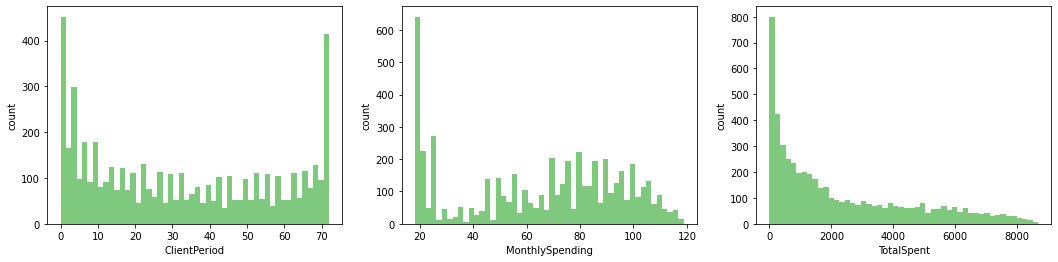

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, col in enumerate(num_cols):
  ax = axes[np.unravel_index(i, shape=axes.shape)]
  ax.hist(df[col], bins=50, color=colors[0])
  ax.set_xlabel(col)
  ax.set_ylabel('count')

Ящики с усами:

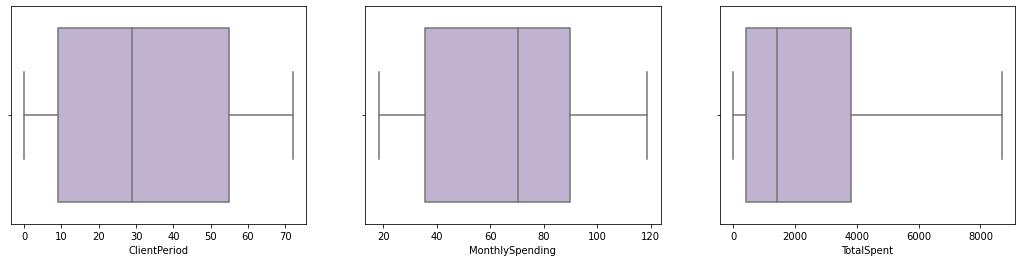

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, col in enumerate(num_cols):
  ax = axes[np.unravel_index(i, shape=axes.shape)]
  sns.boxplot(x=col, data=df, ax=ax, color=colors[1])

Будем считать, что выбросов не наблюдается, так как ни для одного графика нет точек, выходящих за промежуток значений, заданный усами графика.

### Категориальные признаки

Посмотрим на распределение данных по признакам, воспользовавшись методом value_counts():

In [ ]:
for col in cat_cols:
  print(col)
  print(df[col].value_counts())
  print()

Sex
Male      2647
Female    2621
Name: Sex, dtype: int64

IsSeniorCitizen
0    4427
1     841
Name: IsSeniorCitizen, dtype: int64

HasPartner
No     2691
Yes    2577
Name: HasPartner, dtype: int64

HasChild
No     3662
Yes    1606
Name: HasChild, dtype: int64

HasPhoneService
Yes    4747
No      521
Name: HasPhoneService, dtype: int64

HasMultiplePhoneNumbers
No                  2497
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64

HasInternetService
Fiber optic    2335
DSL            1798
No             1135
Name: HasInternetService, dtype: int64

HasOnlineSecurityService
No                     2604
Yes                    1529
No internet service    1135
Name: HasOnlineSecurityService, dtype: int64

HasOnlineBackup
No                     2324
Yes                    1809
No internet service    1135
Name: HasOnlineBackup, dtype: int64

HasDeviceProtection
No                     2309
Yes                    1824
No internet service    1135
Na

Кажется, наблюдается небольшая избыточность в данных. Есть столбец `HasInternetService`, указывающий на наличие интернета. В то же время есть  несколько столбцов, обозначающих наличие какой-то дополнительной услуги (например, HasMovieSubscription), у них встречаются значения 'No', 'Yes' и 'No internet service'. Выходит, 'No' указывает на отсутствие дополнительной услуги, как и 'No interent service', только еще дублируя информацию об отсутствии интернета, хотя это нам не так важно для колонок такого типа. Можно легко заменить 'No interent service' на 'No', не утратив информацию о наличии интернета.

In [ ]:
nis_cols = []
for col in cat_cols:
  if 'No internet service' in df[col].values:
    nis_cols.append(col)
print(nis_cols)

['HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription']


In [ ]:
for col in nis_cols:
  df.loc[df[col] == 'No internet service', col] = 'No'
  print(f'{col}: {df[col].unique()}')

HasOnlineSecurityService: ['No' 'Yes']
HasOnlineBackup: ['No' 'Yes']
HasDeviceProtection: ['No' 'Yes']
HasTechSupportAccess: ['No' 'Yes']
HasOnlineTV: ['No' 'Yes']
HasMovieSubscription: ['No' 'Yes']


Построим круговые диаграммы:

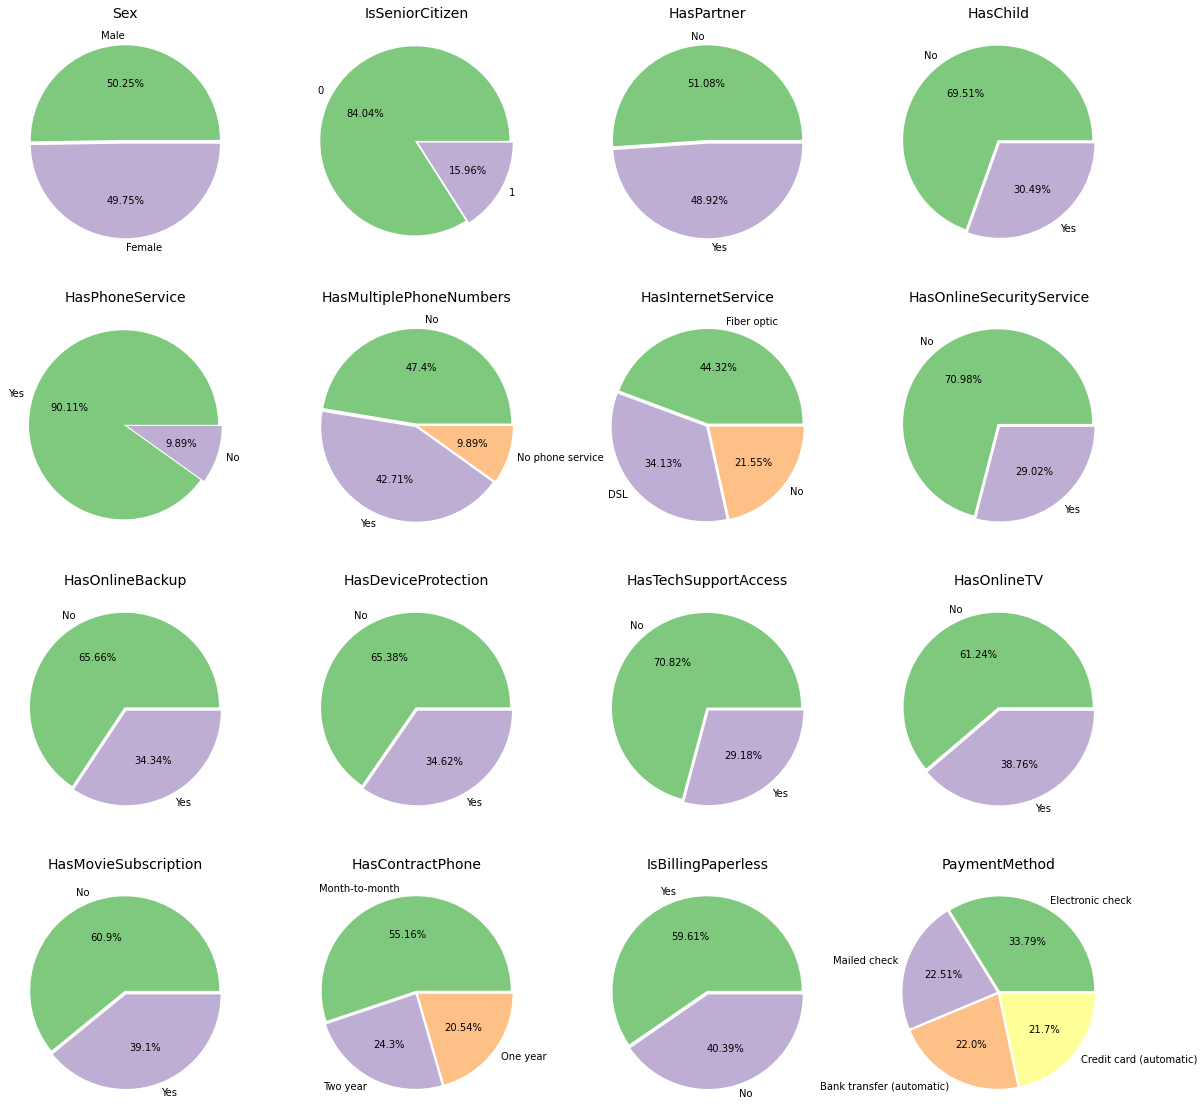

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i, col in enumerate(cat_cols):
  vc = df[col].value_counts()
  labels = vc.index
  x = vc.values
  ax = axes[np.unravel_index(i, shape=axes.shape)]
  ax.set_title(label=col, fontdict={'fontsize': 14})
  ax.pie(x=x, explode=(0.02,)*len(x), labels=labels, colors=colors, 
         autopct=lambda percent: f'{round(percent, 2)}%')

### Целевая переменная

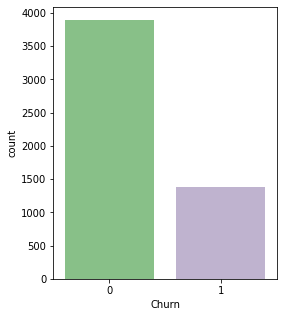

In [ ]:
plt.figure(figsize=(4, 5))
sns.countplot(x=target_col, data=df, palette=colors);

In [ ]:
df[target_col].value_counts(normalize=True)

0    0.73918
1    0.26082
Name: Churn, dtype: float64

In [ ]:
0.73918 / 0.26082

2.834061805076298

Класса 0 почти в три раза больше класса 1. Сильного дисбаланса классов все же нет.

## Применение линейных моделей (3 балла)

Применим one-hot encoding к категориальным признакам.

In [ ]:
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_cat = df[cat_cols]
data = enc.fit_transform(X_cat)
columns = enc.get_feature_names(cat_cols)
X_cat = pd.DataFrame(data=data, columns=columns, dtype='int64')
X_num = df[num_cols]
X = pd.concat([X_num, X_cat], axis=1)
y = df[target_col]
X.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55,19.50,1026.35,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0
2,1,75.90,75.90,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0
3,32,79.30,2570.00,1,0,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1
4,60,115.25,6758.45,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0


Разделим выборку на обучение и тест в соотношении 80:20.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Выберем лучшие параметры penalty и C, используя кросс-валидацию. В GridSearchCV будем передавать пайплайн из нормализации MinMaxScaler и логистической регрессии.

In [ ]:
pipeline = make_pipeline(
    MinMaxScaler(),
    LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear', max_iter=200)
)

params = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

lr_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    scoring='roc_auc',
    refit=True,
    cv=5,
    verbose=0
)

lr_grid.fit(X_train, y_train);

Лучшие параметры:

In [ ]:
best_params = lr_grid.best_params_
for param_name in best_params:
  print(f'{param_name}: {best_params[param_name]}')

logisticregression__C: 100
logisticregression__penalty: l2


Лучшее значение метрики ROC AUC:

In [ ]:
lr_grid.best_score_

0.8442607133535059

In [ ]:
def plot_roc_auc(estimator, X_train, X_test, y_train, y_test, title):
  y_train_pred = estimator.predict_proba(X_train)[:, 1]
  y_test_pred = estimator.predict_proba(X_test)[:, 1]

  train_roc_auc = roc_auc_score(y_train, y_train_pred, average='weighted')  
  test_roc_auc = roc_auc_score(y_test, y_test_pred, average='weighted')

  fpr_train, tpr_train = roc_curve(y_train, y_train_pred)[:2]
  fpr_test, tpr_test = roc_curve(y_test, y_test_pred)[:2]
  
  plt.figure(figsize=(11, 6))
  plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC: {round(train_roc_auc, 5)}')
  plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC: {round(test_roc_auc, 5)}')
  plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  plt.title(title)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()

Вычислим качество на обучении и тесте:

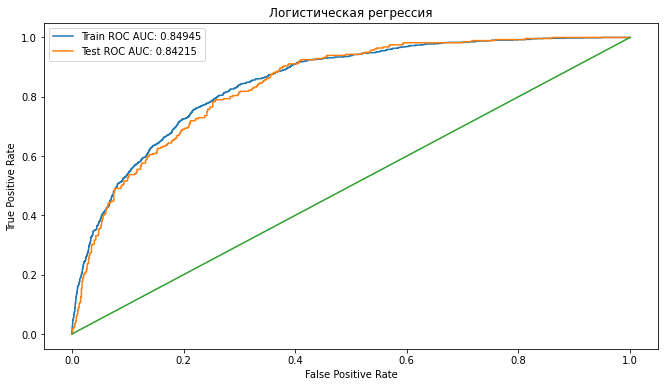

In [ ]:
plot_roc_auc(lr_grid, X_train, X_test, y_train, y_test, 'Логистическая регрессия')

### Kaggle

Обработаем пропуски в тесте как и в обучении:

In [ ]:
test = pd.read_csv('test.csv')
test[test['TotalSpent'] == ' '] = 0
df['TotalSpent'] = pd.to_numeric(df['TotalSpent'])
test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


* Обучим модель c лучшими параметрами на всем датафрейме
* Предобработаем данные теста: отнормируем числовые признаки и закодируем категориальные признаки. Сделаем предсказания

In [ ]:
data = enc.transform(test[cat_cols])
columns = enc.get_feature_names(cat_cols)
test_cat = pd.DataFrame(data=data, columns=columns, dtype='int64')
test_without_normalization = pd.concat([test[num_cols], test_cat], axis=1)
test_without_normalization.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,42,56.10,2386.85,0,1,1,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0
1,29,98.50,3004.15,0,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0
2,9,76.25,684.85,0,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
3,67,74.00,4868.4,1,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0
4,71,20.10,1389.6,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0


In [ ]:
mms = MinMaxScaler()
train = mms.fit_transform(X)
data = mms.transform(test_without_normalization)
test_with_normalization = pd.DataFrame(data=data, columns=test_without_normalization.columns)
test_with_normalization.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.583333,0.376617,0.274831,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.402778,0.798507,0.345909,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.125000,0.577114,0.078856,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.930556,0.554726,0.560566,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.986111,0.018408,0.160004,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
lr_best = LogisticRegression(penalty='l2', C=100, class_weight='balanced', 
                             random_state=42, solver='liblinear', max_iter=200)
lr_best.fit(train, y);

In [ ]:
submission = pd.read_csv('submission.csv')
submission['Churn'] = lr_best.predict_proba(test_with_normalization)[:, 1]
submission.to_csv('lr_submission.csv', index=False)

In [ ]:
submission['Churn']

0       0.111584
1       0.884296
2       0.848596
3       0.018167
4       0.003804
          ...   
1756    0.224958
1757    0.057027
1758    0.881198
1759    0.834052
1760    0.029939
Name: Churn, Length: 1761, dtype: float64

Результат: 0.84496

## Решающее дерево

Выберем лучшие параметры criterion, max_depth, min_samples_leaf и max_features, используя кросс-валидацию. Здесь уже не нужно нормировать числовые признаки.

In [ ]:
dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced')

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 30),
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': ['sqrt', 'log2']
}

dtc_grid = GridSearchCV(
    estimator=dtc,
    param_grid=params,
    scoring='roc_auc',
    refit=True,
    cv=5,
    verbose=0
)

dtc_grid.fit(X_train, y_train);

Лучшие параметры:

In [ ]:
best_params = dtc_grid.best_params_
for param_name in best_params:
  print(f'{param_name}: {best_params[param_name]}')

criterion: entropy
max_depth: 12
max_features: log2
min_samples_leaf: 20


Лучшее значение метрики ROC AUC:

In [ ]:
dtc_grid.best_score_

0.8115939327732716

Вычислим качество на обучении и тесте:

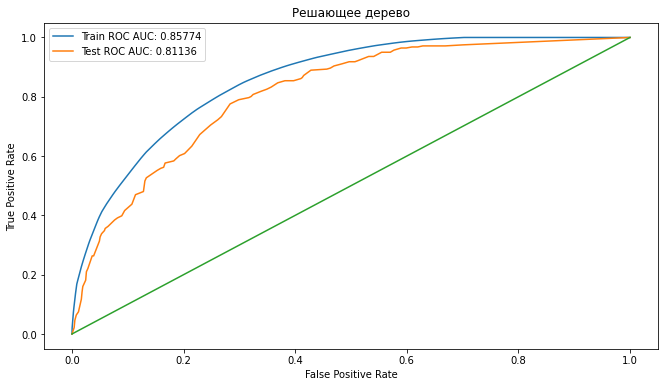

In [ ]:
plot_roc_auc(dtc_grid, X_train, X_test, y_train, y_test, 'Решающее дерево')

### Kaggle

Обучим модель с лучшими параметрами на всем датфрейме и сделаем предсказания:

In [ ]:
dtc_best = DecisionTreeClassifier(criterion='entropy', max_depth=12, max_features='log2', 
                                  min_samples_leaf=20, random_state=42, class_weight='balanced')
dtc_best.fit(X, y);

In [ ]:
submission = pd.read_csv('submission.csv')
submission['Churn'] = dtc_best.predict_proba(test_without_normalization)[:, 1]
submission.to_csv('dtc_submission.csv', index=False)

In [ ]:
submission['Churn']

0       0.281044
1       0.802148
2       0.908418
3       0.000000
4       0.000000
          ...   
1756    0.414696
1757    0.000000
1758    0.706655
1759    0.837047
1760    0.000000
Name: Churn, Length: 1761, dtype: float64

Результат: 0.81378

## Случайный лес

Выберем лучшие параметры n_estimators, max_depth и min_samples_leaf, используя кросс-валидацию. Здесь уже не нужно нормировать числовые признаки.

In [ ]:
rfc = RandomForestClassifier(criterion='entropy', max_features='log2', 
                             random_state=42, class_weight='balanced', n_jobs=-1)

params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 20, 50]
}

rfc_grid = GridSearchCV(
    estimator=rfc,
    param_grid=params,
    scoring='roc_auc',
    refit=True,
    cv=5,
    verbose=0,
    n_jobs=-1
)

rfc_grid.fit(X_train, y_train);

Лучшие параметры:

In [ ]:
best_params = rfc_grid.best_params_
for param_name in best_params:
  print(f'{param_name}: {best_params[param_name]}')

max_depth: 20
min_samples_leaf: 10
n_estimators: 50


Лучшее значение метрики ROC AUC:

In [ ]:
rfc_grid.best_score_

0.8458911780897109

Вычислим качество на обучении и тесте:

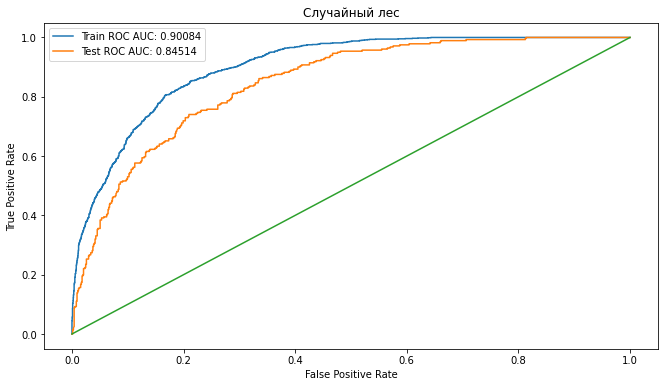

In [ ]:
plot_roc_auc(rfc_grid, X_train, X_test, y_train, y_test, 'Случайный лес')

### Kaggle

Обучим модель с лучшими параметрами на всем датфрейме и сделаем предсказания:

In [ ]:
rfc_best = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=20, max_features='log2', 
                                  min_samples_leaf=10, random_state=42, class_weight='balanced')
rfc_best.fit(X, y);

In [ ]:
submission = pd.read_csv('submission.csv')
submission['Churn'] = rfc_best.predict_proba(test_without_normalization)[:, 1]
submission.to_csv('rfc_submission.csv', index=False)

In [ ]:
submission['Churn']

0       0.118310
1       0.857134
2       0.799558
3       0.051675
4       0.036345
          ...   
1756    0.382722
1757    0.101550
1758    0.905821
1759    0.726410
1760    0.014040
Name: Churn, Length: 1761, dtype: float64

Результат:0.84787

## Применение градиентного бустинга (2 балла)

In [ ]:
X = df[feature_cols]
y = df[target_col]

Пока разделим выборку на обучение и тест в соотношении 80:20 и протестируем catboost co стандартными параметрами.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
cbc = CatBoostClassifier(cat_features=cat_cols, random_seed=42)
cbc.fit(X_train, y_train, verbose=False);

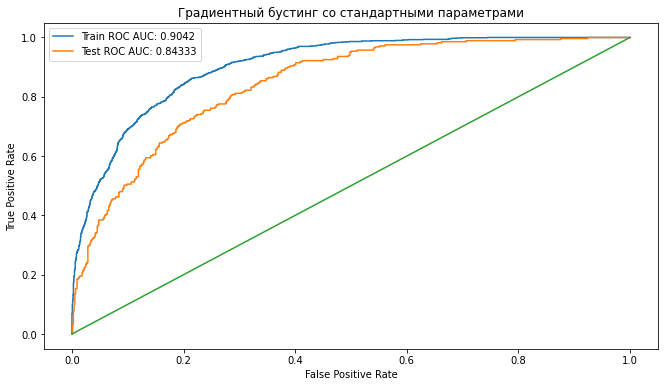

In [ ]:
plot_roc_auc(cbc, X_train, X_test, y_train, y_test, 'Градиентный бустинг со стандартными параметрами')

Теперь еще раз разделим выборку, но уже на обучение, валидацию и тест в соотношении 70:15:15. Используем валидационную выборку для выбора лучшего количества деревьев и learning rate:

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [ ]:
train_scores = []
val_scores = []
params = []
for n_trees in [50, 100, 300, 500]:
  for lr in [0.03, 0.05, 0.3, 0.5]:
    cbc = CatBoostClassifier(iterations=n_trees, learning_rate=lr, random_seed=42, 
                            class_weights=[0.7, 0.3], cat_features=cat_cols)
    cbc.fit(X_train, y_train, verbose=False)
    y_train_pred = cbc.predict_proba(X_train)[:, 1]
    y_val_pred = cbc.predict_proba(X_val)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_train_pred)  
    val_roc_auc = roc_auc_score(y_val, y_val_pred)
    train_scores.append(train_roc_auc)
    val_scores.append(val_roc_auc)
    params.append({'n_trees': n_trees, 'learning_rate': lr})

Лучшие параметры и лучшее качество по метрике ROC AUC:

In [ ]:
best_model_idx = np.argmax(val_scores)
best_params = params[best_model_idx]
for param_name in best_params:
  print(f'{param_name}: {best_params[param_name]}')
print(max(val_scores))

n_trees: 300
learning_rate: 0.03
0.8360070493868845


Качество на обучении и тесте:

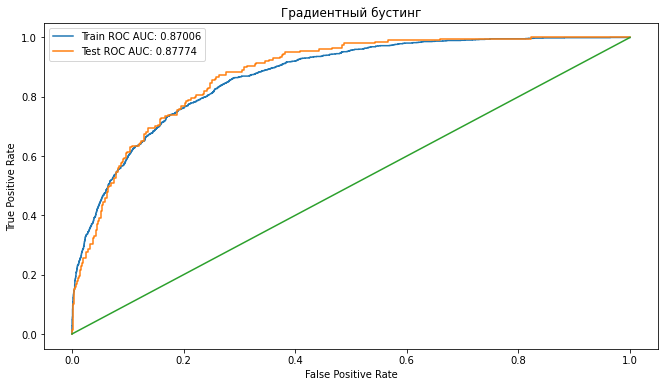

In [ ]:
cbc = CatBoostClassifier(iterations=300, learning_rate=0.03, random_seed=42, 
                        class_weights=[0.7, 0.3], cat_features=cat_cols)
X_train = pd.DataFrame(data=np.vstack((X_train, X_rem)), columns=X_train.columns)
y_train = np.hstack((y_train, y_rem))
cbc.fit(X_train, y_train, verbose=False)
plot_roc_auc(cbc, X_train, X_test, y_train, y_test, 'Градиентный бустинг')

Из всех моделей catboost дает лучший результат, ее и будем использовать, чтобы сделать финальные предсказания.

## Предсказания

Обучим модель на всем датафрейме и сделаем предсказания

In [ ]:
cbc_best = CatBoostClassifier(iterations=300, learning_rate=0.03, random_seed=42, 
                              class_weights=[0.7, 0.3], cat_features=cat_cols)
cbc_best.fit(X, y, verbose=False);

In [ ]:
submission = pd.read_csv('submission.csv')
test = pd.read_csv('test.csv')
submission['Churn'] = cbc_best.predict_proba(test)[:, 1]
submission.to_csv('cbc_submission.csv', index=False)

In [ ]:
submission['Churn']

0       0.012840
1       0.492583
2       0.441989
3       0.005056
4       0.002118
          ...   
1756    0.064793
1757    0.005406
1758    0.710882
1759    0.358411
1760    0.007663
Name: Churn, Length: 1761, dtype: float64

Результат: 0.85322